In [10]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)
library(car)
library(ggplot2)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(ggeffects)


filename <- 'generated/num_of_review_comments.csv'

data <- read.csv(file=filename, header=TRUE, sep=",")

data$LanguageType = as.factor(data$LanguageType)

data$EffectiveComments = log(data$EffectiveComments + 1)
data$Additions = log(data$Additions + 1)
data$Deletions = log(data$Deletions + 1)
data$TotalReviewComments = log(data$TotalReviewComments + 1)
data$TotalReviewCommentThreads = log(data$TotalReviewCommentThreads + 1)
data$GeneralComments = log(data$GeneralComments + 1)
data$Commits = log(data$Commits + 1)
data$Assignees = log(data$Assignees + 1)
data$ChangedFiles = log(data$ChangedFiles + 1)
data$PrOpenedDaysAfterProjectStart = log(data$PrOpenedDaysAfterProjectStart + 1)
data$NumOfUniqueUsers = log(data$NumOfUniqueUsers + 1)
data$PRsOpened = log(data$PRsOpened + 1)
data$TotalBuilds = log(data$TotalBuilds + 1)
data$AdditionsAfterCreate = log(data$AdditionsAfterCreate + 1)
data$CommitsAfterCreate = log(data$CommitsAfterCreate + 1)
data$DeletionsAfterCreate = log(data$DeletionsAfterCreate + 1)

summary(data)

 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.00000   Min.   :0.0000      Min.   :0.0000           
 1st Qu.:0.00000   1st Qu.:0.0000      1st Qu.:0.0000           
 Median :0.00000   Median :0.0000      Median :0.0000           
 Mean   :0.07763   Mean   :0.3053      Mean   :0.2835           
 3rd Qu.:0.00000   3rd Qu.:0.0000      3rd Qu.:0.0000           
 Max.   :5.56068   Max.   :6.0039      Max.   :6.0039           
                                                                
 ShareReviewComments GeneralComments  GeneralCommentsDiscussingBuild
 Min.   :  0.00      Min.   :0.0000   Min.   :0                     
 1st Qu.:  0.00      1st Qu.:0.0000   1st Qu.:0                     
 Median :  0.00      Median :0.6931   Median :0                     
 Mean   : 10.66      Mean   :0.8845   Mean   :0                     
 3rd Qu.:  0.00      3rd Qu.:1.3863   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.9431   Max.   :0                   

# Introduction

First we model if the number of commits after opening the pull request is influenced in any way by the presence of Travis

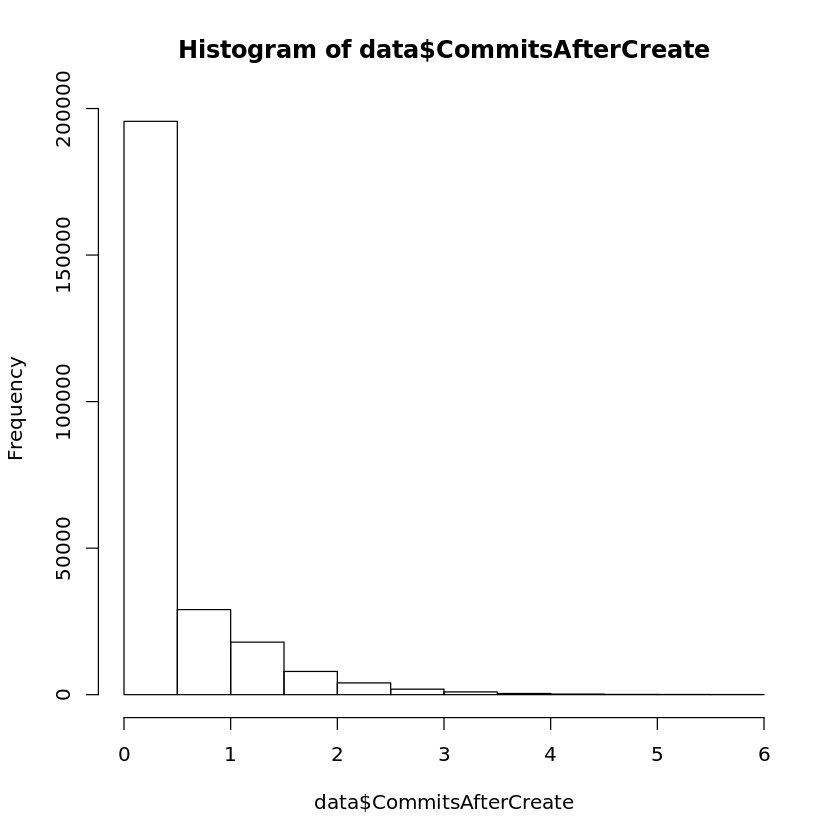

In [11]:
hist(data$CommitsAfterCreate)


	Wilcoxon rank sum test with continuity correction

data:  data[data$IsAfter == "False", ]$CommitsAfterCreate + 1 and data[data$IsAfter == "True", ]$CommitsAfterCreate + 1
W = 7991600000, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


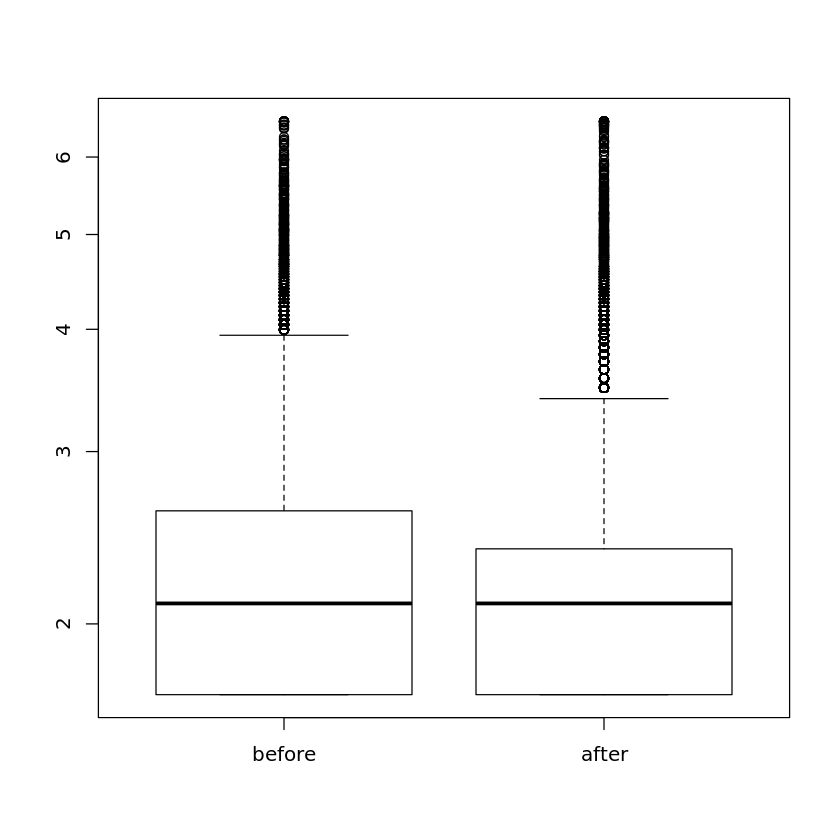

In [31]:
boxplot(list(before = data[data$IsAfter == 'False' & data$CommitsAfterCreate > 0,]$CommitsAfterCreate + 1, after = data[data$IsAfter == 'True'& data$CommitsAfterCreate > 0,]$CommitsAfterCreate + 1 ), log='y')

wilcox.test(data[data$IsAfter == 'False',]$CommitsAfterCreate + 1, data[data$IsAfter == 'True',]$CommitsAfterCreate + 1 )

From this plot it can be easily be observed that we require a hurdle model to correctly model the effect that Travis has on `CommitsAfterCreate`

In [12]:
hasCommitsAfterCreate <- sqldf('select * from data where CommitsAfterCreate > 0 and LanguageType != "unk"')

zerosdf <- sqldf('select * from "data" where CommitsAfterCreate = 0 and LanguageType != "unk"')

sampledZerosdf <- zerosdf[sample(nrow(zerosdf), nrow(hasCommitsAfterCreate)),]

combined <- rbind(sampledZerosdf, hasCommitsAfterCreate)

executeLmOnData <- function(formula, data) {
    model = lm(formula ,
          data= data)
    print(summary(model))
    #r.squaredGLMM(model)
    print(vif(model))
    print(anova(model))
    
    return(model)
}

# Base model
This model first does a hurdle model to look at predicting whether a pull request has any commits after create. Then it does a linear regression to predict the number of commits after create. 

In [33]:
baseHurdleModel = glm((CommitsAfterCreate > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            #NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            LanguageType +
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModel)
r.squaredGLMM(baseHurdleModel)
vif(baseHurdleModel)
anova(baseHurdleModel)


Call:
glm(formula = (CommitsAfterCreate > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    LanguageType + IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.5378  -0.6606  -0.0534   0.6840   2.8353  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.383323   0.081207 -53.977  < 2e-16 ***
Additions                      0.120140   0.006705  17.918  < 2e-16 ***
Deletions                     -0.023714   0.006825  -3.475 0.000511 ***
IsMergedTrue                   0.421024   0.020620  20.419  < 2e-16 ***
Commits                        1.997516   0.019381 103.063  < 2e-16 ***
LinterTrue                     0.041542   0.016998   2.444 0.014527 *  
CoverageT

R2m       R2c 
0.6521759 0.6521759

Additions                     Deletions 
                     2.986506                      2.494515 
                     IsMerged                       Commits 
                     1.175426                      1.232303 
                       Linter                      Coverage 
                     1.048879                      1.093785 
                    Assignees                  ChangedFiles 
                     1.025022                      3.305652 
                    PRsOpened                   TotalBuilds 
                     3.008135                      3.495126 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.760326                      1.770808 
                 FromOutsider     TotalReviewCommentThreads 
                     1.869289                      1.071339 
              GeneralComments                  LanguageType 
                     1.124861                      1.211333 
                      IsAfter 
                     4.227599

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,104031,144218.97
Additions,1,10035.016732,104030,134183.96
Deletions,1,3.377500,104029,134180.58
IsMerged,1,80.819666,104028,134099.76
Commits,1,27848.057396,104027,106251.70
Linter,1,95.445707,104026,106156.26
Coverage,1,30.977290,104025,106125.28
Assignees,1,430.202096,104024,105695.08
ChangedFiles,1,504.981742,104023,105190.10
PRsOpened,1,23.878504,104022,105166.22


In [34]:
baseModel <- executeLmOnData(
            CommitsAfterCreate ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            Linter +
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            TotalReviewComments + 
            #TotalReviewCommentThreads +
            GeneralComments +
            LanguageType +
                IsAfter ,
        hasCommitsAfterCreate
        )


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3972 -0.1668  0.0019  0.2198  2.1304 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -0.1418243  0.0176471  -8.037 9.42e-16 ***
Additions                      0.0006506  0.0013423   0.485 0.627898    
Deletions                     -0.0021903  0.0012949  -1.692 0.090744 .  
IsMergedTrue                   0.0084338  0.0042558   1.982 0.047516 *  
Commits                        0.6395512  0.0028197 226.814  < 2e-16 ***
Assignees                      0.0393918  0.0079426   4.960 7.09e-07 ***
LinterTrue                     0.0204161  0.0036071   5.660 1.52e-08 ***
CoverageTrue                   0.0135149  0.0036840   3.668 0.000244 ***
ChangedFiles                  -0.0157257  0.0028756  -5.469 4.56e-08 ***
NumOfUniqueUsers              -0.1367836  0.0060539 -22.594  < 2e-16 ***
PRsOpened                      0.0041877  0.00

# Interaction between Linter, Coverage, and Travis introduction


Call:
glm(formula = (CommitsAfterCreate > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + PRsOpened + 
    TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    LanguageType + Coverage * Linter * IsAfter, family = "binomial", 
    data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.5458  -0.6603  -0.0500   0.6834   2.8320  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -4.371156   0.083030 -52.646  < 2e-16 ***
Additions                            0.119490   0.006709  17.810  < 2e-16 ***
Deletions                           -0.023645   0.006827  -3.463 0.000534 ***
IsMergedTrue                         0.422641   0.020635  20.482  < 2e-16 ***
Commits                              1.995089   0.019387 102.908  < 2e-16 ***
Assignees                            0.4

R2m       R2c 
0.6525984 0.6525984

Additions                     Deletions 
                     2.987565                      2.494926 
                     IsMerged                       Commits 
                     1.175895                      1.232752 
                    Assignees                  ChangedFiles 
                     1.026625                      3.306155 
                    PRsOpened                   TotalBuilds 
                     3.028199                      3.518138 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.763922                      1.779293 
                 FromOutsider     TotalReviewCommentThreads 
                     1.891943                      1.080610 
              GeneralComments                  LanguageType 
                     1.129478                      1.249530 
                     Coverage                        Linter 
                     5.074654                      3.510034 
                      IsAfter               Coverage:Linter 
                     7.228732                      6.589537 
             Coverage:IsAfter                Linter:IsAfter 
                     6.705161                      5.962635 
      Coverage:Linter:IsAfter 
                     7.653494

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,104031,144218.97
Additions,1,1.003502e+04,104030,134183.96
Deletions,1,3.377500e+00,104029,134180.58
IsMerged,1,8.081967e+01,104028,134099.76
Commits,1,2.784806e+04,104027,106251.70
Assignees,1,3.986000e+02,104026,105853.10
ChangedFiles,1,4.995057e+02,104025,105353.60
PRsOpened,1,2.026585e+01,104024,105333.33
TotalBuilds,1,2.367844e+03,104023,102965.49
NewContributor,1,6.344356e+00,104022,102959.14


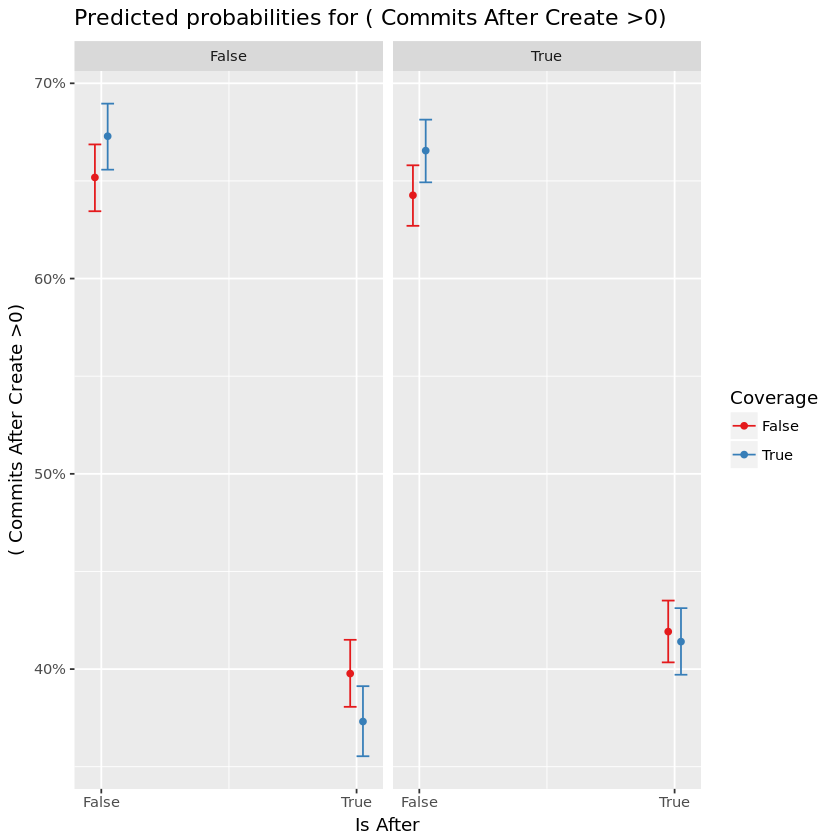

In [35]:
hurdleModelInteractionCoverageLinter = glm((CommitsAfterCreate > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            #NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            LanguageType +
            Coverage *
            Linter *
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverageLinter)
r.squaredGLMM(hurdleModelInteractionCoverageLinter)
vif(hurdleModelInteractionCoverageLinter)
anova(hurdleModelInteractionCoverageLinter)

plot_model(hurdleModelInteractionCoverageLinter, type="pred", terms=c('IsAfter', 'Coverage', 'Linter'))


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4376 -0.1670  0.0039  0.2209  2.1380 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -0.1411698  0.0181286  -7.787 6.98e-15 ***
Additions                            0.0007953  0.0013434   0.592  0.55383    
Deletions                           -0.0019644  0.0012955  -1.516  0.12944    
IsMergedTrue                         0.0116474  0.0042572   2.736  0.00622 ** 
Commits                              0.6392651  0.0028243 226.343  < 2e-16 ***
Assignees                            0.0422201  0.0079514   5.310 1.10e-07 ***
ChangedFiles                        -0.0159315  0.0028772  -5.537 3.09e-08 ***
NumOfUniqueUsers                    -0.1258020  0.0059974 -20.976  < 2e-16 ***
PRsOpened                            0.0044153  0.0014868   2.970  0.00298 ** 
TotalBuilds                          0.1054662  0.0037182  

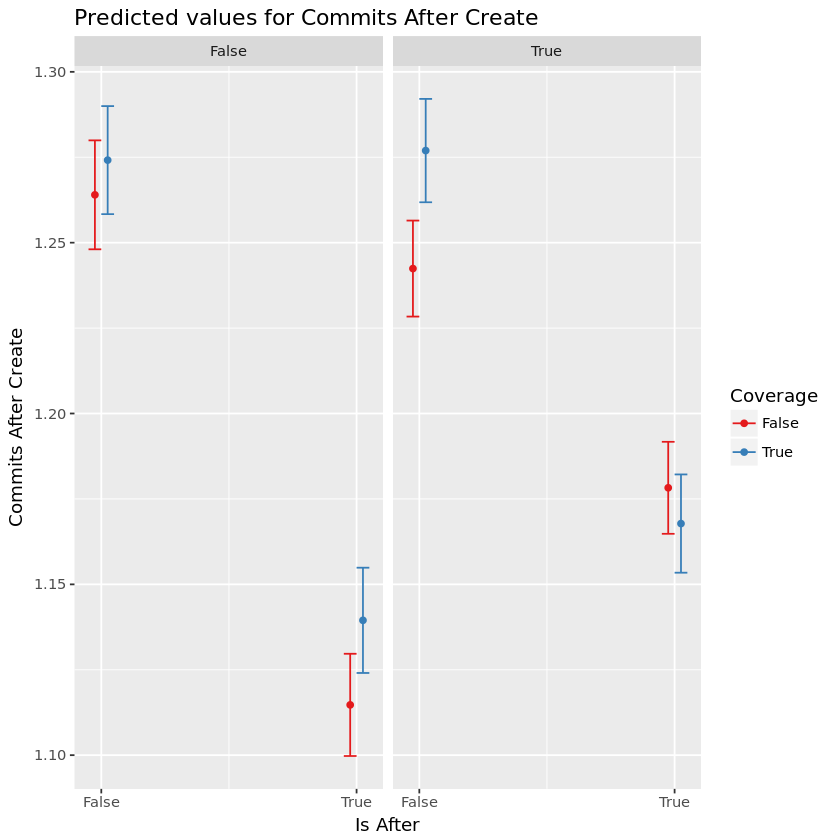

In [36]:
modelInteractionCoverageLinter <- executeLmOnData(
            CommitsAfterCreate ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments +
            LanguageType +
            Coverage *
            Linter *
                IsAfter ,
        hasCommitsAfterCreate
        )

plot_model(modelInteractionCoverageLinter, type="pred", terms=c('IsAfter', 'Coverage', 'Linter'))